In [1]:
# lstm for time series forecasting
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import time
from datetime import datetime
from tensorflow import math
from tensorflow import reduce_mean
import tensorflow as tf
import sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    print('X: \n', X[0:5], '\n Y: \n', y[0:5])
    return asarray(X), asarray(y)

In [3]:
# Need new function to evaluate RMSE based on just 'Percent Output'
# Current state: we have input tensors of shape (None [batch size], 21). Need to find a way to turn that into an "array of losses"
# of shape (None, 21). Then return that.
# Current step: figure out how to index through a tensor. Need to only focus on solar output
def custom_loss(y_actual, y_pred):
    SE_Tensor = math.square(y_pred - y_actual)  #squared difference
    MSE = reduce_mean(SE_Tensor, axis=0)
    #RMSE = tf.math.sqrt(MSE)
    
    Zeros = tf.zeros_like(MSE) #create tensor of zeros
    Mask = [False, False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, False, False, False, False, True] #create mask
    Solar_MSE = tf.where(Mask, MSE, Zeros) #create tensor where every loss is 0 except solar output
    
    #print_output = tf.print(Solar_MSE, "Solar_MSE: ")
    
    return Solar_MSE

In [4]:
# Need to make a custom evaluation metric as well as loss function
# RMSE should be between 0 and 1. Giving RMSEs of 20+ and not dropping below 1. Something is wrong here.
def custom_eval(y_actual, y_pred):
    SE_Tensor = math.square(y_pred - y_actual)  #squared difference
    MSE = reduce_mean(SE_Tensor, axis=0)
    
    Zeros = tf.zeros_like(MSE) #create tensor of zeros
    Mask = [False, False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, False, False, False, False, True] #create mask
    Solar_MSE = tf.where(Mask, MSE, Zeros) #create tensor where every loss is 0 except solar output
    
    Solar_RMSE = tf.math.sqrt(Solar_MSE)
    
    #print_output = tf.print(Solar_RMSE, "Solar_RMSE: ")
    
    return Solar_RMSE

In [5]:
# load the dataset
df = read_csv("SolarTrainingData.csv", index_col=0)

In [6]:
# Create holdout set
PREDICTION_SET_SIZE = 580
N_STEPS = 5

df_holdout = df.iloc[-PREDICTION_SET_SIZE:]
df = df.iloc[:-PREDICTION_SET_SIZE]

holdout_X, holdout_y = split_sequence(df_holdout.values.astype('float32'), N_STEPS)

X: 
 [array([[ 6.4599998e+01,  6.4599998e+01,  6.2299999e+01,  9.2379997e+01,
         9.9999998e-03,  0.0000000e+00,  0.0000000e+00,  2.2200001e+01,
         1.2600000e+01,  1.3100000e+02,  1.0134000e+03,  1.0000000e+02,
         9.1999998e+00,  2.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         2.0180000e+03,  1.2000000e+01,  2.6000000e+01,  8.0000000e+00,
        -1.3104014e-03],
       [ 6.4599998e+01,  6.4599998e+01,  6.2299999e+01,  9.2379997e+01,
         9.9999998e-03,  0.0000000e+00,  0.0000000e+00,  2.2200001e+01,
         1.2600000e+01,  1.3100000e+02,  1.0134000e+03,  1.0000000e+02,
         9.1999998e+00,  2.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         2.0180000e+03,  1.2000000e+01,  2.6000000e+01,  8.0000000e+00,
        -5.7142857e-04],
       [ 6.4599998e+01,  6.4599998e+01,  6.2299999e+01,  9.2379997e+01,
         9.9999998e-03,  0.0000000e+00,  0.0000000e+00,  2.2200001e+01,
         1.2600000e+01,  1.3100000e+02,  1.0134000e+03,  1.0000000e+02,
        

In [10]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size
n_steps = 5
# split into samples
X, y = split_sequence(values, n_steps)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 21))
# split into train/test
n_test = 2400
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]

X: 
 [array([[6.5000000e+01, 6.5000000e+01, 5.7799999e+01, 7.7510002e+01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.8299999e+01,
        7.5999999e+00, 2.3800000e+02, 1.0149000e+03, 1.0000000e+02,
        9.8999996e+00, 2.7900000e+02, 1.0000000e+00, 3.0000000e+00,
        2.0180000e+03, 1.1000000e+01, 2.3000000e+01, 1.1000000e+01,
        3.2047620e-01],
       [6.5000000e+01, 6.5000000e+01, 5.7799999e+01, 7.7510002e+01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.8299999e+01,
        7.5999999e+00, 2.3800000e+02, 1.0149000e+03, 1.0000000e+02,
        9.8999996e+00, 2.7900000e+02, 1.0000000e+00, 3.0000000e+00,
        2.0180000e+03, 1.1000000e+01, 2.3000000e+01, 1.1000000e+01,
        2.5557300e-01],
       [6.5000000e+01, 6.5000000e+01, 5.7799999e+01, 7.7510002e+01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.8299999e+01,
        7.5999999e+00, 2.3800000e+02, 1.0149000e+03, 1.0000000e+02,
        9.8999996e+00, 2.7900000e+02, 1.0000000e+00, 3.0000000

In [11]:
# define model
# improvement area : try adding dropout
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,21)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_eval])
#model.compile(optimizer='adam', loss='mse', metrics=[custom_eval])

In [12]:
# fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(X_test, y_test))
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

Epoch 1/10
662/662 - 8s - loss: 1179.0659 - custom_eval: 2.4460 - val_loss: 3.5615 - val_custom_eval: 0.3701 - 8s/epoch - 12ms/step
Epoch 2/10
662/662 - 3s - loss: 7.2494 - custom_eval: 0.5323 - val_loss: 3.8280 - val_custom_eval: 0.3848 - 3s/epoch - 4ms/step
Epoch 3/10
662/662 - 3s - loss: 3.9729 - custom_eval: 0.4201 - val_loss: 4.3357 - val_custom_eval: 0.4117 - 3s/epoch - 4ms/step
Epoch 4/10
662/662 - 3s - loss: 2.1845 - custom_eval: 0.3121 - val_loss: 1.8867 - val_custom_eval: 0.2701 - 3s/epoch - 4ms/step
Epoch 5/10
662/662 - 3s - loss: 1.4311 - custom_eval: 0.2525 - val_loss: 4.8962 - val_custom_eval: 0.4657 - 3s/epoch - 4ms/step
Epoch 6/10
662/662 - 3s - loss: 1.4514 - custom_eval: 0.2481 - val_loss: 0.5573 - val_custom_eval: 0.1457 - 3s/epoch - 4ms/step
Epoch 7/10
662/662 - 3s - loss: 1.1179 - custom_eval: 0.2171 - val_loss: 2.8282 - val_custom_eval: 0.3584 - 3s/epoch - 4ms/step
Epoch 8/10
662/662 - 3s - loss: 1.5344 - custom_eval: 0.2489 - val_loss: 0.2945 - val_custom_eval: 0

In [ ]:
# make a prediction
#row = asarray([18024.0, 16722.0, 14385.0, 21342.0, 17180.0]).reshape((1, n_steps, 1))
#yhat = model.predict(row)
#print('Predicted: %.3f' % (yhat))

18/18 [==============================] - 0s 3ms/step
[[-3.7754364e+00]
 [-3.7753372e+00]
 [-3.7752075e+00]
 [-3.7750397e+00]
 [-3.7750778e+00]
 [-3.7755814e+00]
 [-3.7755432e+00]
 [-3.6568985e+00]
 [-3.8566055e+00]
 [-3.8832321e+00]
 [-4.0352936e+00]
 [-4.1566925e+00]
 [-4.1568909e+00]
 [-4.1568375e+00]
 [-4.1572571e+00]
 [-4.1570511e+00]
 [-4.1569672e+00]
 [-4.1573181e+00]
 [-4.1574707e+00]
 [-4.1572571e+00]
 [-4.1572952e+00]
 [-4.1575394e+00]
 [-4.1572876e+00]
 [-3.9665298e+00]
 [-3.4457932e+00]
 [-3.2723007e+00]
 [-3.8153305e+00]
 [-5.0563202e+00]
 [-5.0562668e+00]
 [-5.0560150e+00]
 [-5.0568542e+00]
 [-5.0561905e+00]
 [-5.0557861e+00]
 [-5.0573654e+00]
 [-5.0566483e+00]
 [-5.0569077e+00]
 [-5.0569153e+00]
 [-5.0567856e+00]
 [-5.0563202e+00]
 [-4.6665649e+00]
 [-4.6021271e+00]
 [-4.2369080e+00]
 [-4.2310181e+00]
 [-4.1705017e+00]
 [-4.1708832e+00]
 [-4.1710587e+00]
 [-4.1712341e+00]
 [-4.1710052e+00]
 [-4.1703339e+00]
 [-4.1716232e+00]
 [-4.1707077e+00]
 [-4.1710510e+00]
 [-4.171516

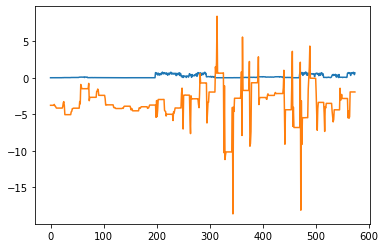

In [13]:
# Make prediction using holdout set
yhat = model.predict(holdout_X)
print(yhat)
figure, axis = plt.subplots(1, 1)
axis.plot([i for i in range(len(holdout_y))], holdout_y[:, -1])
axis.plot([i for i in range(len(yhat))], yhat)
plt.show()
#plt.savefig("Solar Forecasting/matplotlib.png")

In [ ]:
#holdyDF = pd.DataFrame(holdout_y)
#holdyDF.head()

#print(holdout_y[:,-1])

#difference = rehat - holdout_y[:,-1]
#sq_difference = np.square(difference)
#sum_sq = np.sum(sq_difference)
#MSE = sum_sq/580
#print(MSE)

#rehat = np.reshape(yhat, (1, 575))
#print(rehat)

In [9]:
print(holdout_X.shape)

(575, 5, 21)
